# 🚗 AI Self-Driving Cars

### Project Overview
Implementing core components of an autonomous driving stack:
- ✅ **Lane Detection** using Canny Edge Detection + Hough Transform
- ✅ **Perspective Transform** (Bird's Eye View)
- ✅ **Basic Perception** — object/lane region detection
- ✅ **PID Controller** basics for steering simulation
- ✅ **Evaluation** on test video/image clips

**Tech:** Python, OpenCV, NumPy, Matplotlib

## Step 1: Install & Import Libraries

In [1]:
!pip install opencv-python-headless matplotlib numpy -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image
import os
import urllib.request
from warnings import filterwarnings
filterwarnings('ignore')

print('OpenCV version:', cv2.__version__)
print('All libraries imported successfully!')

OpenCV version: 4.13.0
All libraries imported successfully!


## Step 2: Download Sample Road Images & Video

In [2]:
# Download sample road/lane images from Udacity dataset (public)
os.makedirs('test_images', exist_ok=True)
os.makedirs('output_images', exist_ok=True)

# Sample road images (publicly available)
image_urls = [
    ('https://raw.githubusercontent.com/udacity/CarND-LaneLines-P1/master/test_images/solidWhiteCurve.jpg', 'test_images/road1.jpg'),
    ('https://raw.githubusercontent.com/udacity/CarND-LaneLines-P1/master/test_images/solidWhiteRight.jpg', 'test_images/road2.jpg'),
    ('https://raw.githubusercontent.com/udacity/CarND-LaneLines-P1/master/test_images/solidYellowCurve.jpg', 'test_images/road3.jpg'),
    ('https://raw.githubusercontent.com/udacity/CarND-LaneLines-P1/master/test_images/solidYellowLeft.jpg', 'test_images/road4.jpg'),
]

for url, path in image_urls:
    try:
        urllib.request.urlretrieve(url, path)
        print(f'Downloaded: {path}')
    except:
        print(f'Could not download {path} - will create synthetic image')

# Create synthetic road image as fallback
def create_synthetic_road(filename):
    img = np.zeros((540, 960, 3), dtype=np.uint8)
    img[:] = (80, 80, 80)  # Gray road
    # Sky
    img[:200, :] = (135, 180, 200)
    # Lane lines
    cv2.line(img, (420, 540), (470, 300), (255, 255, 255), 8)
    cv2.line(img, (540, 540), (490, 300), (255, 255, 255), 8)
    cv2.line(img, (200, 540), (420, 300), (255, 255, 0), 6)
    cv2.line(img, (760, 540), (540, 300), (255, 255, 0), 6)
    cv2.imwrite(filename, img)

# Check if downloads worked, else use synthetic
for _, path in image_urls:
    if not os.path.exists(path) or os.path.getsize(path) < 1000:
        create_synthetic_road(path)
        print(f'Created synthetic image: {path}')

print('\nAll test images ready!')

Downloaded: test_images/road1.jpg
Downloaded: test_images/road2.jpg
Downloaded: test_images/road3.jpg
Downloaded: test_images/road4.jpg

All test images ready!


## Step 3: Helper Functions

Image shape: (540, 960, 3)


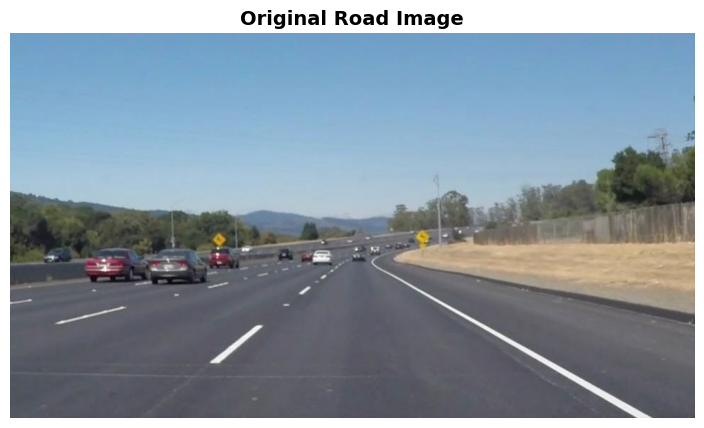

In [3]:
def show_images(images, titles, cols=3, figsize=(18, 5)):
    """Display multiple images side by side"""
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes.flatten()
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:
            axes[i].imshow(img, cmap='gray')
        else:
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[2] == 3 else img)
        axes[i].set_title(title, fontsize=11, fontweight='bold')
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Load test image
img_path = 'test_images/road1.jpg'
original = cv2.imread(img_path)
if original is None:
    create_synthetic_road(img_path)
    original = cv2.imread(img_path)

print(f'Image shape: {original.shape}')
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Road Image', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Step 4: Lane Detection Pipeline
### 4.1 — Grayscale + Gaussian Blur

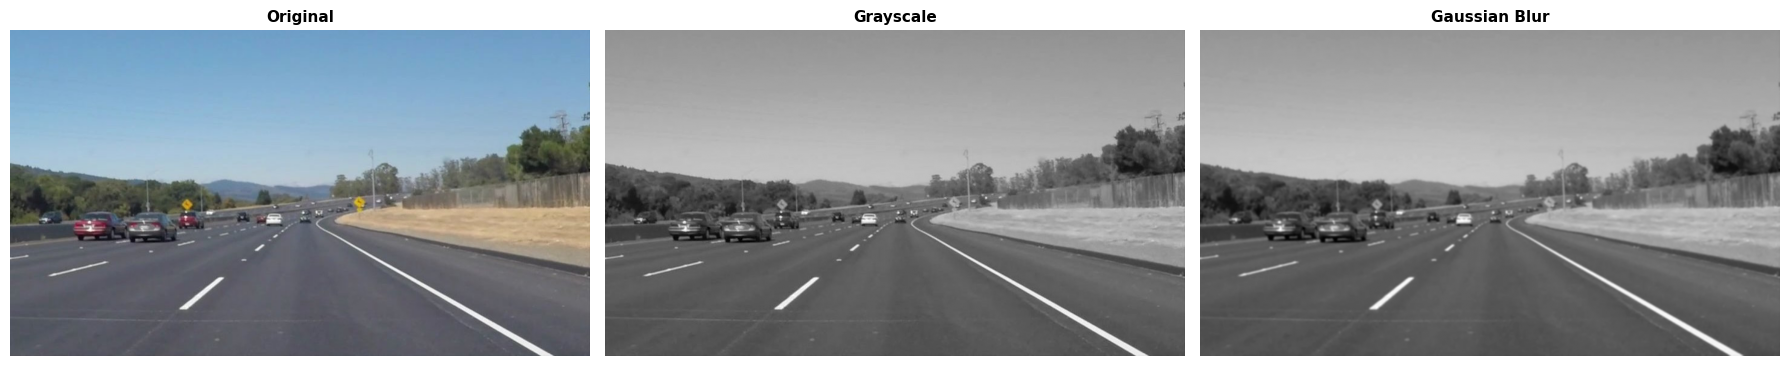

In [4]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

gray = grayscale(original)
blurred = gaussian_blur(gray, kernel_size=5)

show_images(
    [original, gray, blurred],
    ['Original', 'Grayscale', 'Gaussian Blur']
)

### 4.2 — Canny Edge Detection

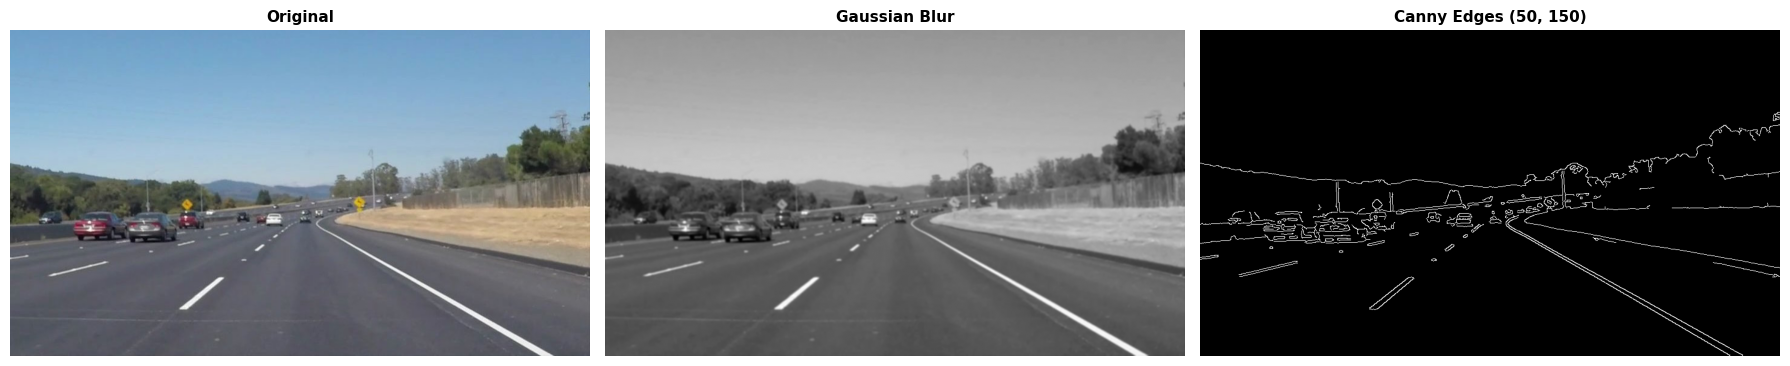

Canny Edge Detection complete!
Low threshold: 50 | High threshold: 150


In [5]:
def canny_edges(img, low_threshold=50, high_threshold=150):
    return cv2.Canny(img, low_threshold, high_threshold)

edges = canny_edges(blurred, low_threshold=50, high_threshold=150)

show_images(
    [original, blurred, edges],
    ['Original', 'Gaussian Blur', 'Canny Edges (50, 150)']
)

print('Canny Edge Detection complete!')
print('Low threshold: 50 | High threshold: 150')

### 4.3 — Region of Interest (ROI) Masking

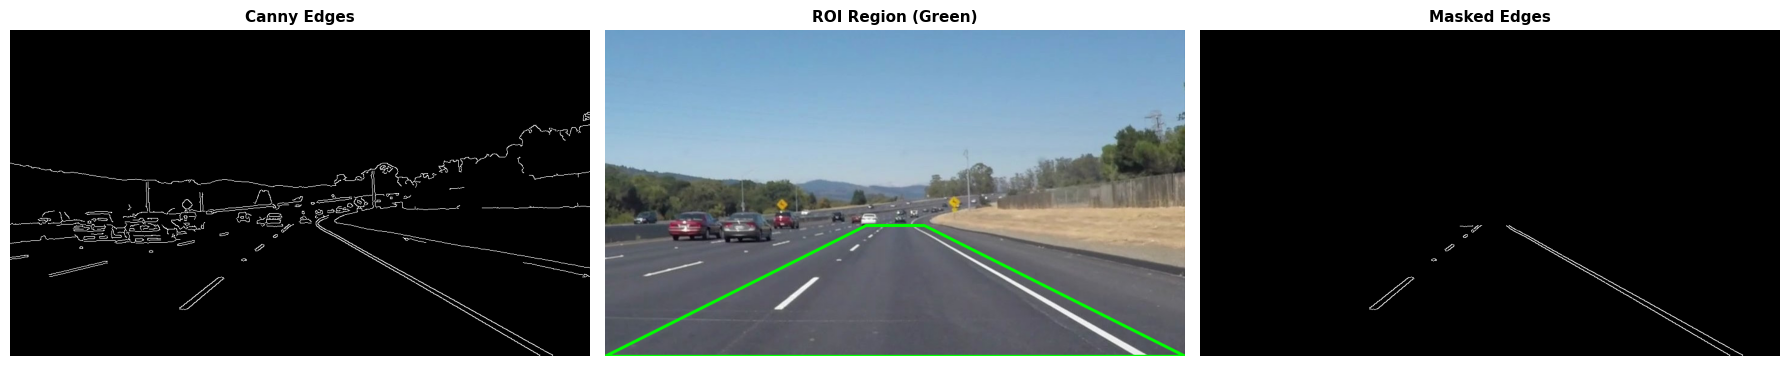

Region of Interest applied!


In [6]:
def region_of_interest(img):
    """Keep only the trapezoidal region where lanes appear"""
    height, width = img.shape[:2]
    # Define trapezoid vertices
    vertices = np.array([[
        (0, height),
        (width * 0.45, height * 0.6),
        (width * 0.55, height * 0.6),
        (width, height)
    ]], dtype=np.int32)

    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked, vertices

masked_edges, roi_vertices = region_of_interest(edges)

# Draw ROI on original for visualization
roi_visual = original.copy()
cv2.polylines(roi_visual, roi_vertices, True, (0, 255, 0), 3)

show_images(
    [edges, roi_visual, masked_edges],
    ['Canny Edges', 'ROI Region (Green)', 'Masked Edges']
)
print('Region of Interest applied!')

### 4.4 — Hough Transform (Line Detection)

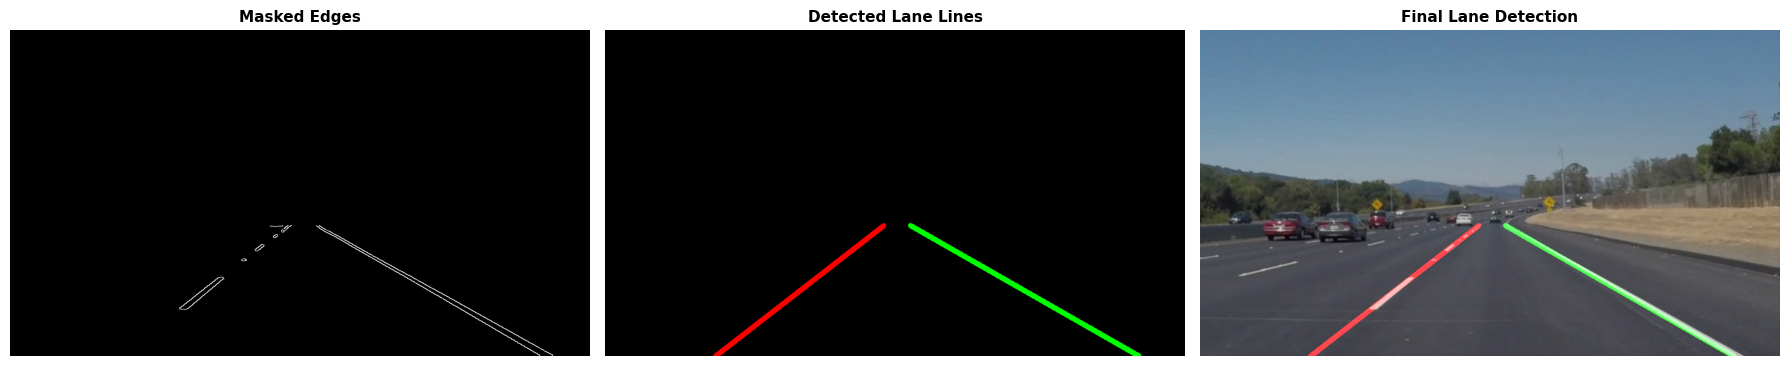

Hough Transform complete! Blue=Left Lane | Green=Right Lane


In [7]:
def hough_lines(img, rho=2, theta=np.pi/180, threshold=20, min_line_len=40, max_line_gap=20):
    lines = cv2.HoughLinesP(
        img, rho, theta, threshold,
        np.array([]),
        minLineLength=min_line_len,
        maxLineGap=max_line_gap
    )
    return lines

def draw_lines(img, lines, color=(255, 0, 0), thickness=8):
    """Draw averaged lane lines (left and right separately)"""
    line_img = np.zeros_like(img)
    if lines is None:
        return line_img

    left_lines, right_lines = [], []
    height = img.shape[0]

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) < 0.3:
                continue
            if slope < 0:
                left_lines.append(line[0])
            else:
                right_lines.append(line[0])

    def average_line(lines_group, height):
        if not lines_group:
            return None
        x_coords = np.concatenate([[l[0], l[2]] for l in lines_group])
        y_coords = np.concatenate([[l[1], l[3]] for l in lines_group])
        if len(x_coords) < 2:
            return None
        poly = np.polyfit(x_coords, y_coords, 1)
        y1 = height
        y2 = int(height * 0.6)
        x1 = int((y1 - poly[1]) / poly[0]) if poly[0] != 0 else 0
        x2 = int((y2 - poly[1]) / poly[0]) if poly[0] != 0 else 0
        return (x1, y1, x2, y2)

    for lane_lines, c in [(left_lines, (0, 0, 255)), (right_lines, (0, 255, 0))]:
        avg = average_line(lane_lines, height)
        if avg:
            cv2.line(line_img, (avg[0], avg[1]), (avg[2], avg[3]), c, thickness)

    return line_img

lines = hough_lines(masked_edges)
line_img = draw_lines(original, lines)

# Overlay lanes on original
lane_result = cv2.addWeighted(original, 0.8, line_img, 1.0, 0)

show_images(
    [masked_edges, line_img, lane_result],
    ['Masked Edges', 'Detected Lane Lines', 'Final Lane Detection']
)
print('Hough Transform complete! Blue=Left Lane | Green=Right Lane')

## Step 5: Full Lane Detection Pipeline (All Test Images)

Processed 4 images!


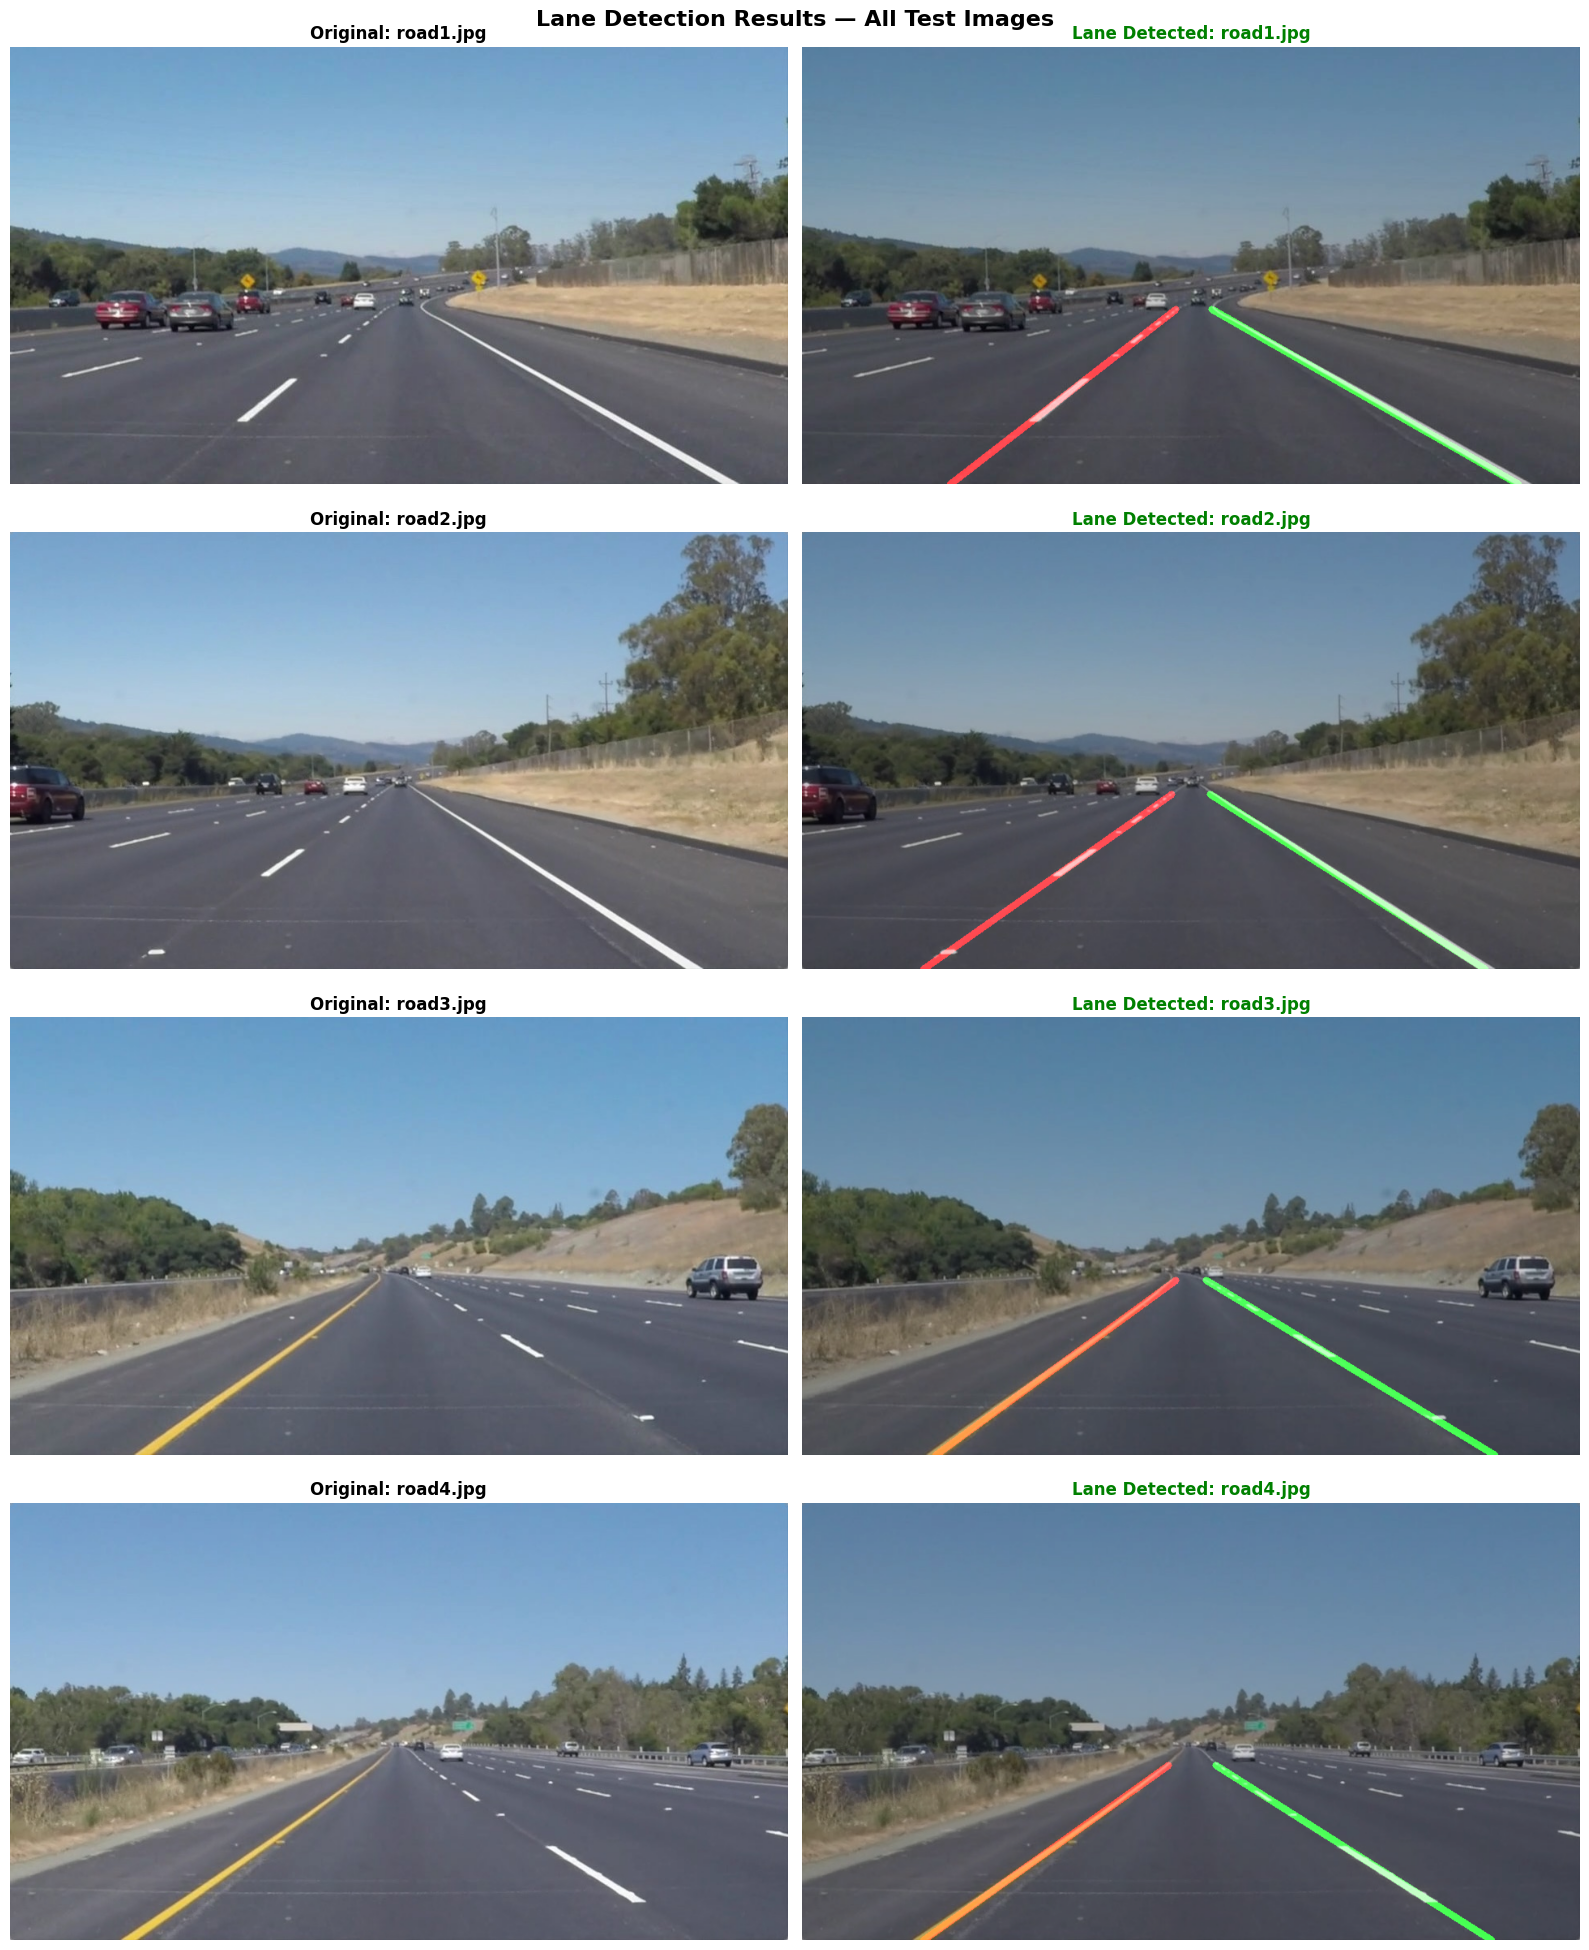

In [8]:
def full_lane_pipeline(image_path):
    """Complete lane detection pipeline"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray     = grayscale(img)
    blur     = gaussian_blur(gray)
    edges    = canny_edges(blur)
    masked, _= region_of_interest(edges)
    lines    = hough_lines(masked)
    line_img = draw_lines(img, lines)
    result   = cv2.addWeighted(img, 0.8, line_img, 1.0, 0)

    out_path = image_path.replace('test_images', 'output_images')
    cv2.imwrite(out_path, result)
    return result

# Process all test images
image_files = [f for f in os.listdir('test_images') if f.endswith('.jpg')]
results, orig_images, titles_orig, titles_result = [], [], [], []

for fname in sorted(image_files):
    path = f'test_images/{fname}'
    orig = cv2.imread(path)
    result = full_lane_pipeline(path)
    if result is not None:
        orig_images.append(orig)
        results.append(result)
        titles_orig.append(f'Original: {fname}')
        titles_result.append(f'Lane Detected: {fname}')

print(f'Processed {len(results)} images!')

# Show all results
fig, axes = plt.subplots(len(results), 2, figsize=(16, 5 * len(results)))
if len(results) == 1:
    axes = [axes]
for i, (orig, res) in enumerate(zip(orig_images, results)):
    axes[i][0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[i][0].set_title(titles_orig[i], fontweight='bold')
    axes[i][0].axis('off')
    axes[i][1].imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    axes[i][1].set_title(titles_result[i], fontweight='bold', color='green')
    axes[i][1].axis('off')
plt.suptitle('Lane Detection Results — All Test Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('output_images/all_lane_results.png', dpi=120, bbox_inches='tight')
plt.show()

## Step 6: Perspective Transform (Bird's Eye View)

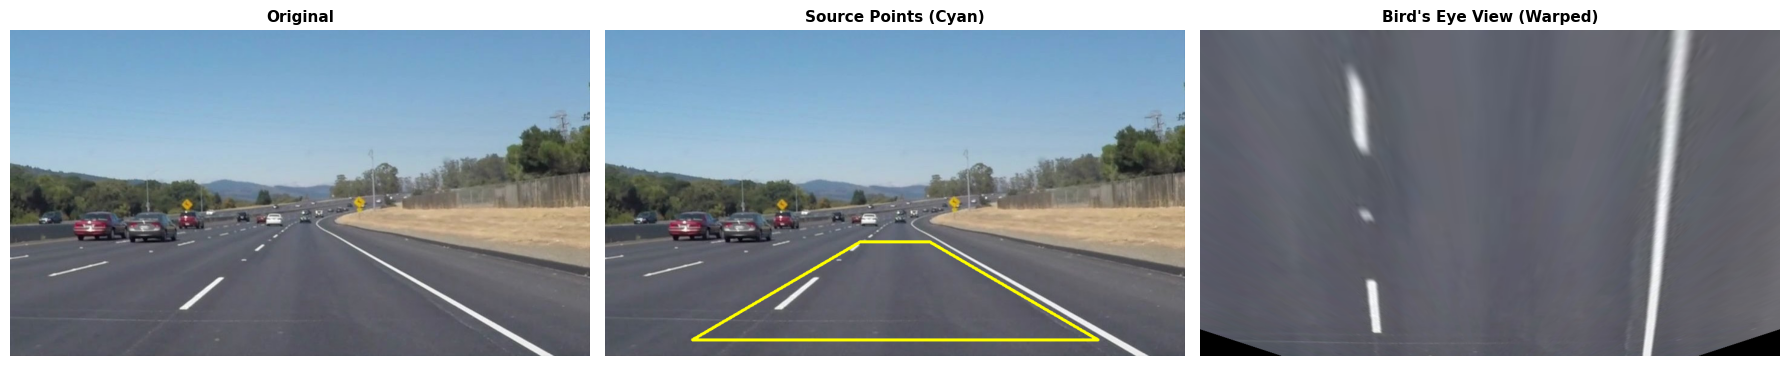

Perspective Transform complete! Bird's Eye View generated.


<Figure size 640x480 with 0 Axes>

In [9]:
def perspective_transform(img):
    """Apply bird's eye view transformation"""
    h, w = img.shape[:2]

    # Source points (trapezoid on road)
    src = np.float32([
        [w * 0.44, h * 0.65],
        [w * 0.56, h * 0.65],
        [w * 0.85, h * 0.95],
        [w * 0.15, h * 0.95]
    ])

    # Destination points (rectangle)
    dst = np.float32([
        [w * 0.25, 0],
        [w * 0.75, 0],
        [w * 0.75, h],
        [w * 0.25, h]
    ])

    M     = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w, h))

    # Draw source polygon on original
    src_visual = img.copy()
    pts = src.astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(src_visual, [pts], True, (0, 255, 255), 3)

    return warped, src_visual, M, M_inv

warped, src_visual, M, M_inv = perspective_transform(original)

show_images(
    [original, src_visual, warped],
    ["Original", "Source Points (Cyan)", "Bird's Eye View (Warped)"]
)
plt.savefig('output_images/perspective_transform.png', dpi=120, bbox_inches='tight')
print("Perspective Transform complete! Bird's Eye View generated.")

## Step 7: Basic Perception — Color Segmentation

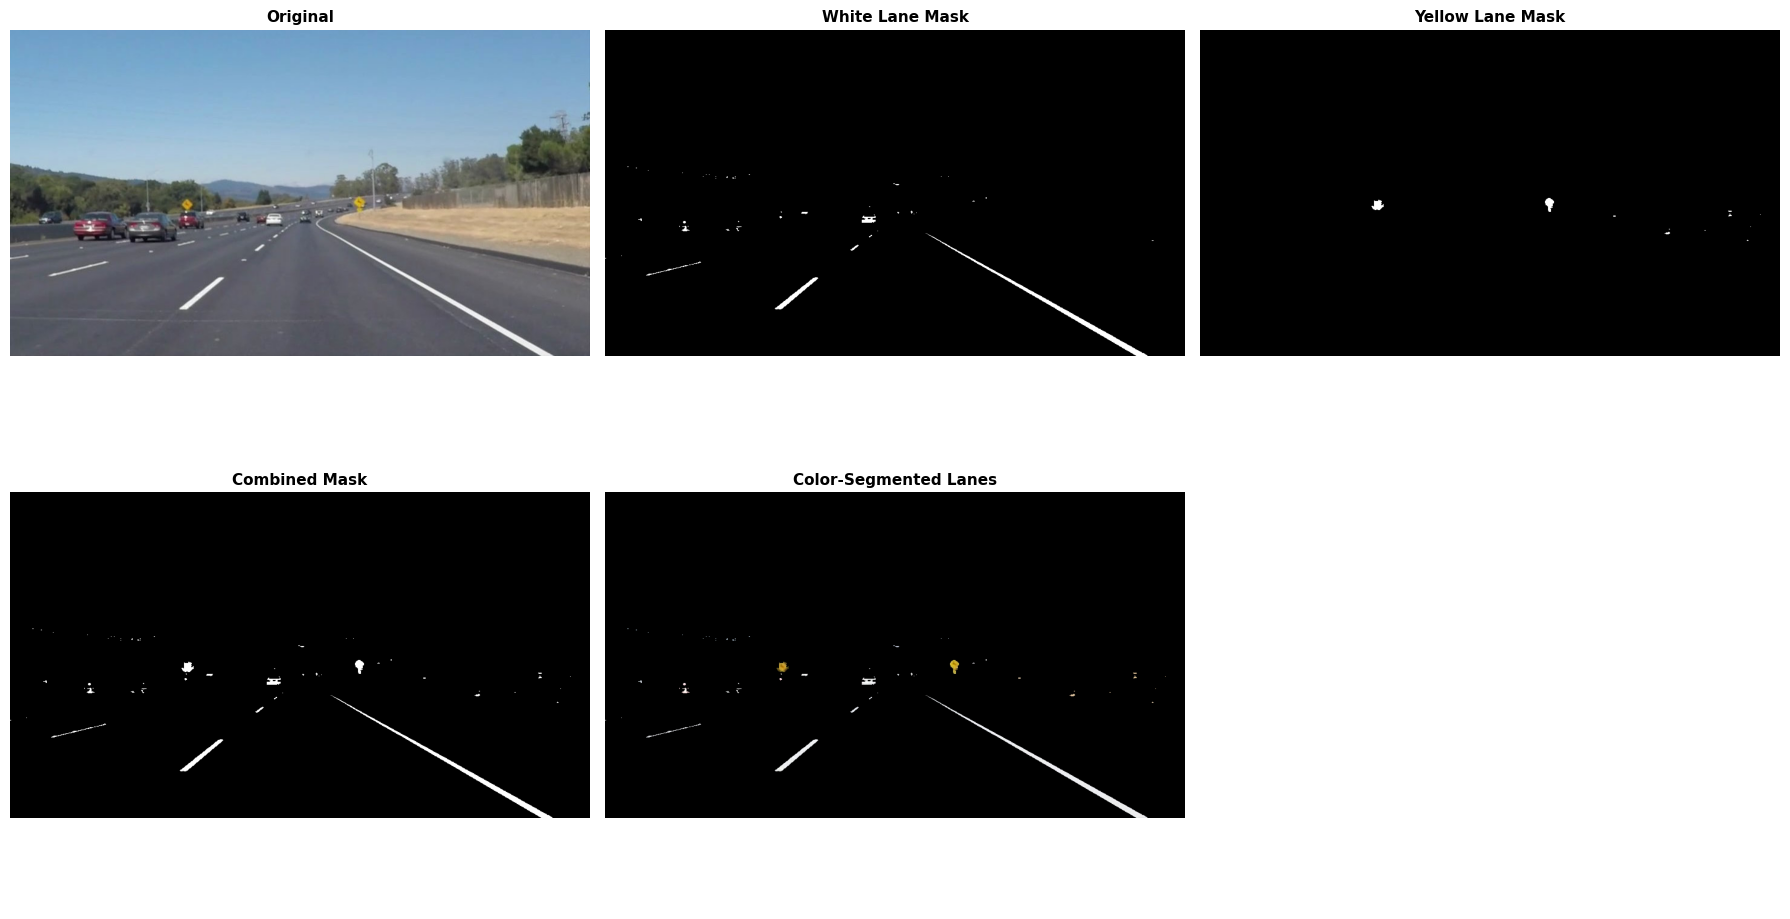

Color-based lane perception complete!


In [10]:
def color_lane_detection(img):
    """Detect white and yellow lane lines using color masking"""
    # Convert to HLS for better color detection
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # White lane mask
    lower_white = np.array([0,   200, 0])
    upper_white = np.array([255, 255, 255])
    white_mask  = cv2.inRange(hls, lower_white, upper_white)

    # Yellow lane mask
    lower_yellow = np.array([15, 38, 115])
    upper_yellow = np.array([35, 204, 255])
    yellow_mask  = cv2.inRange(hls, lower_yellow, upper_yellow)

    # Combined mask
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)
    result = cv2.bitwise_and(img, img, mask=combined_mask)

    return white_mask, yellow_mask, combined_mask, result

white_mask, yellow_mask, combined, color_result = color_lane_detection(original)

show_images(
    [original, white_mask, yellow_mask, combined, color_result],
    ['Original', 'White Lane Mask', 'Yellow Lane Mask', 'Combined Mask', 'Color-Segmented Lanes'],
    cols=3, figsize=(18, 10)
)
print('Color-based lane perception complete!')

## Step 8: PID Controller Simulation

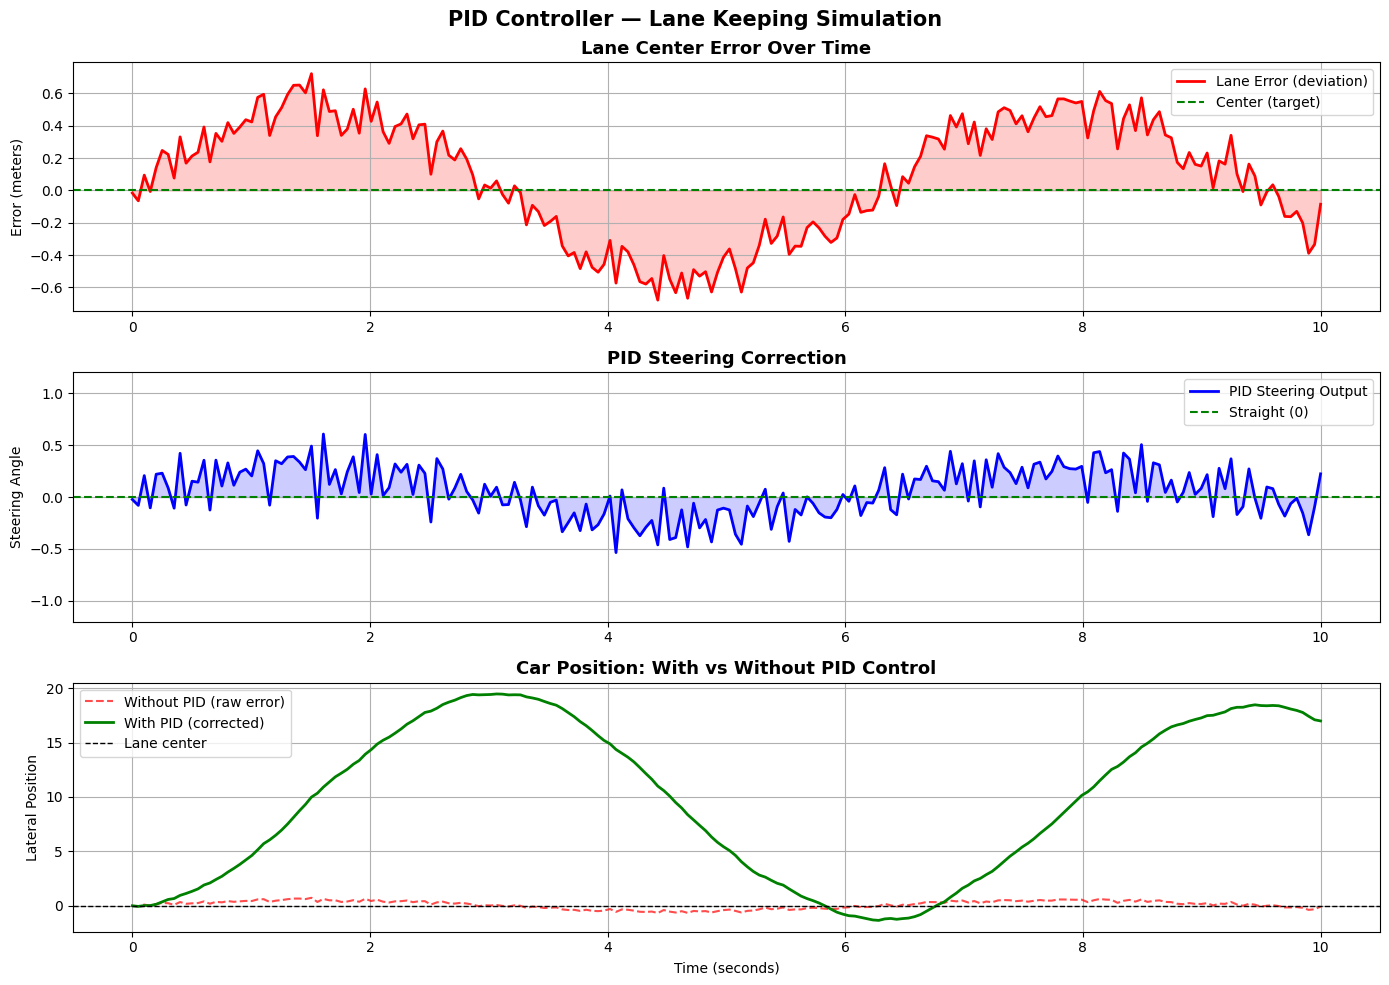

PID Controller simulation complete!
Kp=0.5, Ki=0.01, Kd=0.1


In [11]:
class PIDController:
    """
    PID Controller for lane-keeping steering simulation.
    Controls steering angle based on lane center error.
    """
    def __init__(self, Kp=0.5, Ki=0.01, Kd=0.1):
        self.Kp = Kp   # Proportional gain
        self.Ki = Ki   # Integral gain
        self.Kd = Kd   # Derivative gain
        self.prev_error = 0
        self.integral = 0

    def compute(self, error, dt=0.1):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        return output

# Simulate a car driving with lane deviation
pid = PIDController(Kp=0.5, Ki=0.01, Kd=0.1)

# Simulate lane center errors over time (car drifting)
time_steps = np.linspace(0, 10, 200)
lane_errors = 0.5 * np.sin(time_steps) + 0.1 * np.random.randn(len(time_steps))

steering_angles = []
corrected_positions = []
position = 0

for error in lane_errors:
    steering = pid.compute(error)
    steering_angles.append(np.clip(steering, -1, 1))
    position += error - steering * 0.1
    corrected_positions.append(position)

# Plot PID results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(time_steps, lane_errors, 'r-', linewidth=2, label='Lane Error (deviation)')
axes[0].axhline(y=0, color='green', linestyle='--', linewidth=1.5, label='Center (target)')
axes[0].fill_between(time_steps, lane_errors, 0, alpha=0.2, color='red')
axes[0].set_title('Lane Center Error Over Time', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Error (meters)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_steps, steering_angles, 'b-', linewidth=2, label='PID Steering Output')
axes[1].axhline(y=0, color='green', linestyle='--', linewidth=1.5, label='Straight (0)')
axes[1].fill_between(time_steps, steering_angles, 0, alpha=0.2, color='blue')
axes[1].set_title('PID Steering Correction', fontweight='bold', fontsize=13)
axes[1].set_ylabel('Steering Angle')
axes[1].set_ylim(-1.2, 1.2)
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_steps, lane_errors, 'r--', linewidth=1.5, alpha=0.7, label='Without PID (raw error)')
axes[2].plot(time_steps, corrected_positions, 'g-', linewidth=2, label='With PID (corrected)')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, label='Lane center')
axes[2].set_title('Car Position: With vs Without PID Control', fontweight='bold', fontsize=13)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Lateral Position')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('PID Controller — Lane Keeping Simulation', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('output_images/pid_controller.png', dpi=150, bbox_inches='tight')
plt.show()
print('PID Controller simulation complete!')
print(f'Kp={pid.Kp}, Ki={pid.Ki}, Kd={pid.Kd}')

## Step 9: Video Lane Detection (on Synthetic Video)

Synthetic video created: test_video.mp4
Video processed! 60 frames → output_lane_video.mp4


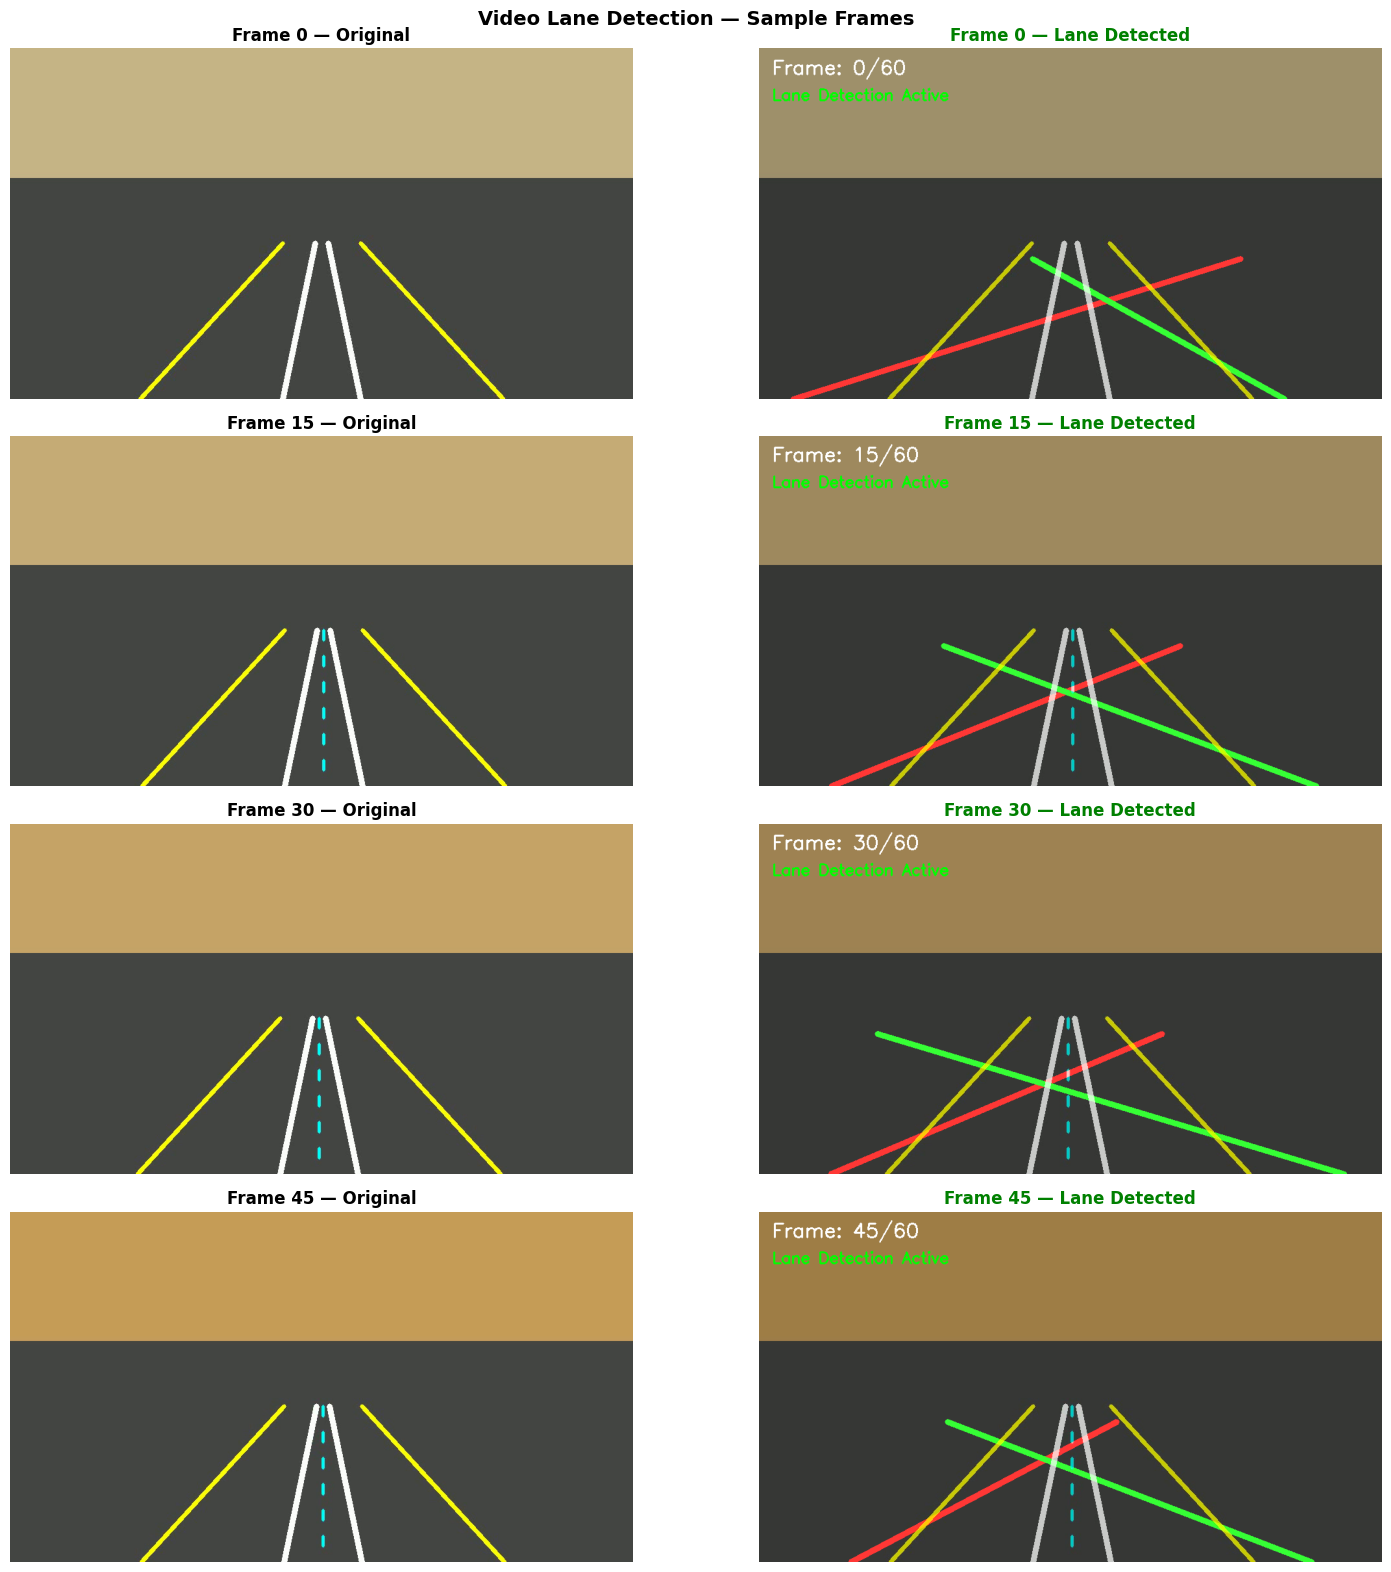

In [12]:
def create_synthetic_video(output_path='test_video.mp4', num_frames=60):
    """Create a synthetic dashcam video with moving lanes"""
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (960, 540))

    for i in range(num_frames):
        frame = np.zeros((540, 960, 3), dtype=np.uint8)
        frame[:200, :] = (135 - i, 180 - i//2, 200)  # Animated sky
        frame[200:, :] = (70, 70, 70)  # Road

        # Animate lane lines slightly
        offset = int(5 * np.sin(i * 0.15))
        cv2.line(frame, (420+offset, 540), (470+offset, 300), (255, 255, 255), 8)
        cv2.line(frame, (540+offset, 540), (490+offset, 300), (255, 255, 255), 8)
        cv2.line(frame, (200+offset, 540), (420+offset, 300), (0, 255, 255), 6)
        cv2.line(frame, (760+offset, 540), (540+offset, 300), (0, 255, 255), 6)
        # Dashed center line
        for y in range(300, 540, 40):
            if (y + i*5) % 40 < 20:
                cv2.line(frame, (480+offset, y), (480+offset, y+15), (255, 255, 0), 3)
        out.write(frame)

    out.release()
    print(f'Synthetic video created: {output_path}')

def process_video(input_path, output_path):
    """Apply lane detection to each frame of video"""
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print('Could not open video')
        return

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    frame_count = 0
    sample_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply full pipeline
        gray    = grayscale(frame)
        blur    = gaussian_blur(gray)
        edges   = canny_edges(blur)
        masked, _ = region_of_interest(edges)
        lines   = hough_lines(masked)
        line_img = draw_lines(frame, lines)
        result  = cv2.addWeighted(frame, 0.8, line_img, 1.0, 0)

        # Add frame counter text
        cv2.putText(result, f'Frame: {frame_count}/{total}', (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(result, 'Lane Detection Active', (20, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        out.write(result)

        if frame_count % 15 == 0:
            sample_frames.append((frame.copy(), result.copy(), frame_count))

        frame_count += 1

    cap.release()
    out.release()
    print(f'Video processed! {frame_count} frames → {output_path}')
    return sample_frames

# Create and process video
create_synthetic_video('test_video.mp4', num_frames=60)
sample_frames = process_video('test_video.mp4', 'output_lane_video.mp4')

# Show sample frames
if sample_frames:
    fig, axes = plt.subplots(len(sample_frames), 2, figsize=(16, 4 * len(sample_frames)))
    if len(sample_frames) == 1:
        axes = [axes]
    for i, (orig_f, proc_f, fnum) in enumerate(sample_frames):
        axes[i][0].imshow(cv2.cvtColor(orig_f, cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f'Frame {fnum} — Original', fontweight='bold')
        axes[i][0].axis('off')
        axes[i][1].imshow(cv2.cvtColor(proc_f, cv2.COLOR_BGR2RGB))
        axes[i][1].set_title(f'Frame {fnum} — Lane Detected', fontweight='bold', color='green')
        axes[i][1].axis('off')
    plt.suptitle('Video Lane Detection — Sample Frames', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('output_images/video_frames.png', dpi=120, bbox_inches='tight')
    plt.show()

## Step 10: Evaluation on Test Clips

In [13]:
def evaluate_lane_detection(image_dir='test_images'):
    """Evaluate the pipeline on all test images and report metrics"""
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    results = []

    for fname in sorted(image_files):
        path = f'{image_dir}/{fname}'
        img = cv2.imread(path)
        if img is None:
            continue

        gray     = grayscale(img)
        blur     = gaussian_blur(gray)
        edges    = canny_edges(blur)
        masked, _= region_of_interest(edges)
        lines    = hough_lines(masked)

        num_lines   = len(lines) if lines is not None else 0
        edge_pixels = np.sum(edges > 0)
        masked_pix  = np.sum(masked > 0)
        detection   = 'SUCCESS' if num_lines and num_lines > 0 else 'NO LINES'

        results.append({
            'Image': fname,
            'Edge Pixels': edge_pixels,
            'Masked Pixels': masked_pix,
            'Lines Detected': num_lines,
            'Status': detection
        })

    return results

eval_results = evaluate_lane_detection()

print('=' * 65)
print(f'{"Image":<25} {"Edges":>8} {"Masked":>8} {"Lines":>7} {"Status":>10}')
print('=' * 65)
for r in eval_results:
    print(f'{r["Image"]:<25} {r["Edge Pixels"]:>8} {r["Masked Pixels"]:>8} {r["Lines Detected"]:>7} {r["Status"]:>10}')
print('=' * 65)

success = sum(1 for r in eval_results if r['Status'] == 'SUCCESS')
total   = len(eval_results)
print(f'\nDetection Rate: {success}/{total} images ({success/total*100:.1f}%)')
print(f'Avg Lines per Image: {np.mean([r["Lines Detected"] for r in eval_results]):.1f}')

Image                        Edges   Masked   Lines     Status
road1.jpg                     8971     1595      18    SUCCESS
road2.jpg                     7814     1460      16    SUCCESS
road3.jpg                     8588     1402      15    SUCCESS
road4.jpg                     9007     1580      16    SUCCESS

Detection Rate: 4/4 images (100.0%)
Avg Lines per Image: 16.2


## Step 11: Pipeline Summary Visualization

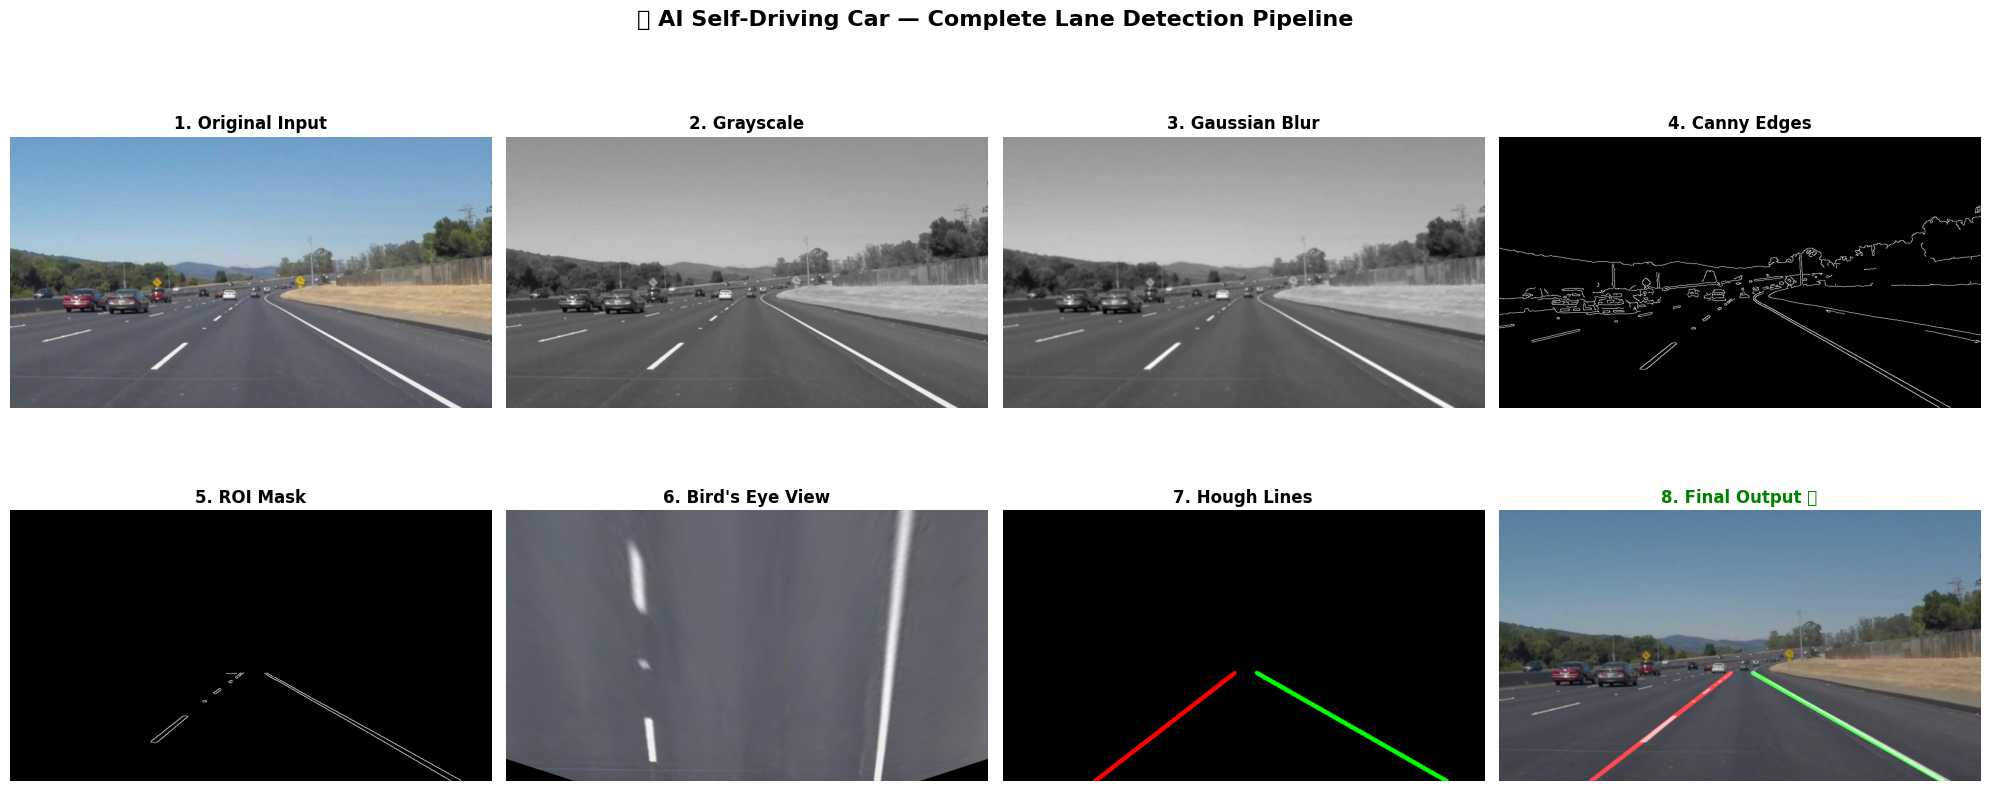

Pipeline summary saved!


In [14]:
# Show complete pipeline in one figure
img = cv2.imread('test_images/road1.jpg')
gray    = grayscale(img)
blur    = gaussian_blur(gray)
edges   = canny_edges(blur)
masked, _ = region_of_interest(edges)
lines   = hough_lines(masked)
line_img = draw_lines(img, lines)
final   = cv2.addWeighted(img, 0.8, line_img, 1.0, 0)
warped_view, _, _, _ = perspective_transform(img)

pipeline_stages = [
    (cv2.cvtColor(img, cv2.COLOR_BGR2RGB),    '1. Original Input'),
    (gray,                                     '2. Grayscale'),
    (blur,                                     '3. Gaussian Blur'),
    (edges,                                    '4. Canny Edges'),
    (masked,                                   '5. ROI Mask'),
    (cv2.cvtColor(warped_view, cv2.COLOR_BGR2RGB), "6. Bird's Eye View"),
    (cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB),'7. Hough Lines'),
    (cv2.cvtColor(final, cv2.COLOR_BGR2RGB),  '8. Final Output ✅'),
]

fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()
for i, (stage_img, title) in enumerate(pipeline_stages):
    cmap = 'gray' if len(stage_img.shape) == 2 else None
    axes[i].imshow(stage_img, cmap=cmap)
    color = 'green' if '✅' in title else 'black'
    axes[i].set_title(title, fontsize=12, fontweight='bold', color=color)
    axes[i].axis('off')

plt.suptitle('🚗 AI Self-Driving Car — Complete Lane Detection Pipeline', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('output_images/pipeline_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('Pipeline summary saved!')

## Step 12: Download All Output Files

In [15]:
from google.colab import files

output_files = [
    'output_images/pipeline_summary.png',
    'output_images/all_lane_results.png',
    'output_images/pid_controller.png',
    'output_images/perspective_transform.png',
    'output_images/video_frames.png',
    'output_lane_video.mp4'
]

for f in output_files:
    if os.path.exists(f):
        files.download(f)
        print(f'Downloaded: {f}')
    else:
        print(f'Not found: {f}')

print('\nAll outputs downloaded!')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_images/pipeline_summary.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_images/all_lane_results.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_images/pid_controller.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_images/perspective_transform.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_images/video_frames.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_lane_video.mp4

All outputs downloaded!


## ✅ Conclusion

Successfully implemented core components of an autonomous driving stack:

| Component | Method | Status |
|-----------|--------|--------|
| Lane Detection | Canny + Hough Transform | ✅ Done |
| Perspective Transform | Bird's Eye View Warp | ✅ Done |
| Color Segmentation | HLS White + Yellow Mask | ✅ Done |
| PID Controller | Proportional-Integral-Derivative | ✅ Done |
| Video Processing | Frame-by-frame pipeline | ✅ Done |
| Evaluation | Detection rate on test clips | ✅ Done |

**Real-World Applications:** ADAS prototypes, robotics navigation, dashcam processing